<a href="https://colab.research.google.com/github/xusky69/dissipative-dynamics/blob/main/qutip_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q qutip

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from qutip import *
sns.set_theme()

# QuTIP dissipative quantum dynamics


In [5]:
def quantumDissipativeCircuit(H_0, V, circuit, rho0, observables, plot = True):
    '''
    Recibe:
        H_0: hamiltoniano del sistema + baño
        V: hamiltoniano de acople baño-sistema, lista de 1 elemento
        circuit: lista de tuplas (Gate, Time) que definen las compuertas y su respectivo tiempo de aplicación
        rho: matriz densidad inicial del sistema
        observables: lista de tuplas (observables, etiquetas), observables a medir y sus respectivas etiquetas
        plot: graficar o no
    Retorna:
        rho: matriz densidad final del sistema
        t : lista de tiempos
        results: valor esperado de los observables para t
    '''

    applyGate = lambda rho, gate : gate*rho*gate.dag()
    circuit.sort(key = lambda arr : arr[1])
    obs = list(map(lambda arr : arr[0], observables))
    labels = list(map(lambda arr : arr[1], observables))
    prev_time = 0
    t_list = []
    results = []
    final_results = []
    rho = rho0

    for gate,time in circuit:
        t = np.linspace(prev_time, time, 100)
        t_list.append(t)
        states = mesolve(H_0, rho, t, V, []).states
        results.append(mesolve(H_0, rho, t, V, obs).expect)
        rho = applyGate(states[-1], gate)
        prev_time = time

    if plot:
        fig = plt.figure(dpi = 80)
        for i in range(len(obs)):
            final_result = np.concatenate(list(map(lambda arr : arr[i], results)))
            final_results.append(final_result)
            plt.plot(np.concatenate(t_list), final_result)
        plt.legend(labels)
        plt.title('Dissipative quantum circuit' if V != [0*H_0] else 'Ideal quantum circuit')
        plt.show(fig)
    else: 
        for i in range(len(obs)):
            final_result = np.concatenate(list(map(lambda arr : arr[i], results)))
            final_results.append(final_result)

    return [rho, np.concatenate(t_list), final_results]

## One qubit circuit

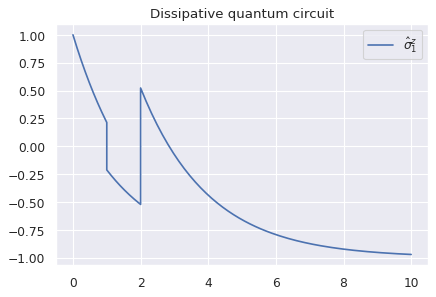

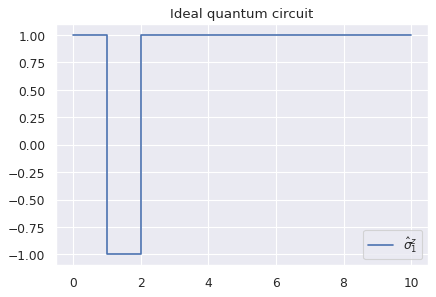

Fidelity between real and dissipative circuits final density matrices is 0.1180877619666356


In [15]:
times = np.linspace(0.0, 10.0, 200)
rho0 = tensor(fock(2,1))
sm  = tensor(destroy(2))
H = sm.dag()*sm 
qI = tensor(qeye(2))

sigma_z1 = -sigmaz()
sigma_x1 = sigmax()

n_b_avg = 0
κ = 0.5
c_ops = [np.sqrt(κ*(1+n_b_avg))*sm, np.sqrt(κ*(n_b_avg))*sm.dag()]

observables = [(sigma_z1, '$\hat{\sigma}_1^z$')] #, (sm.dag()*sm, '$N$')]
circuit = [(sigma_x1,1.0),(sigma_x1,2.0), (qI,10.0)]
# circuit = [(qI, 1.0),(qI, 2.0), (qI, 10.0)]

d_rho, _, _  = quantumDissipativeCircuit(H, c_ops , circuit = circuit, rho0 = rho0, observables = observables, plot = True)
e_rho, _, _  = quantumDissipativeCircuit(H, [0*qI], circuit = circuit, rho0 = rho0, observables = observables, plot = True)

print('Fidelity between real and dissipative circuits final density matrices is {}'.format(fidelity(d_rho, e_rho)))

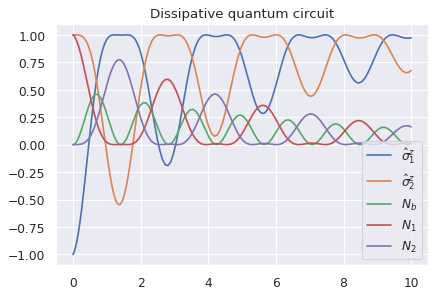

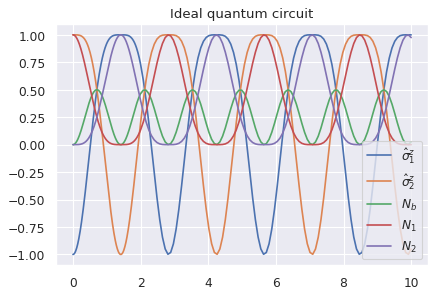

Fidelity between real and dissipative circuits final density matrices is 0.409340113791032


In [7]:
rho0 = tensor(fock(2,1), fock(2,0), fock(10, 0))
rho0 = rho0*rho0.dag()
a  = tensor(qeye(2), qeye(2), destroy(10))
sm1 = tensor(destroy(2), qeye(2)   , qeye(10))
sm2 = tensor(qeye(2)   , destroy(2), qeye(10))
H = 2*np.pi*a.dag()*a + 2*np.pi*sm1.dag()*sm1 + 2*np.pi*sm2.dag()*sm2 + 2*np.pi*0.25*(sm1*a.dag() + sm1.dag()*a) + 2*np.pi*0.25*(sm2*a.dag() + sm2.dag()*a)

n_b_avg = 0
κ = 0.25

c_ops = [np.sqrt(κ*(1+n_b_avg))*sm1,
         np.sqrt(κ*(n_b_avg))*sm1.dag(),
         np.sqrt(κ*(1+n_b_avg))*sm2,
         np.sqrt(κ*(n_b_avg))*sm2.dag(),
         ]

corr_z = tensor(sigmaz(),sigmaz(),qeye(10))
sigma_z1 = tensor(sigmaz(),  qeye(2), qeye(10))
sigma_z2 = tensor( qeye(2), sigmaz(), qeye(10))
sigma_x1 = tensor(sigmax(),  qeye(2), qeye(10))
sigma_x2 = tensor( qeye(2), sigmax(), qeye(10))
qI = tensor(qeye(2),qeye(2),qeye(10))

observables = [(sigma_z1, '$\hat{\sigma}_1^z$'),(sigma_z2, '$\hat{\sigma}_2^z$'), (a.dag()*a, '$N_b$'), (sm1.dag()*sm1, '$N_1$'), (sm2.dag()*sm2, '$N_2$')]
# circuit = [(sigma_x1,1.0),(sigma_x1,2.0), (qI,10.0)]
circuit = [(qI, 1.0),(qI, 2.0), (qI, 10.0)]

d_rho, _, _  = quantumDissipativeCircuit(H, c_ops   , circuit = circuit, rho0 = rho0, observables = observables, plot = True)
e_rho, _, _  = quantumDissipativeCircuit(H, [0*qI], circuit = circuit, rho0 = rho0, observables = observables, plot = True)

print('Fidelity between real and dissipative circuits final density matrices is {}'.format(fidelity(d_rho, e_rho)))